In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import warnings

# Suppress warnings for cleaner output.
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. LOAD AND PREPARE THE DATA -------------------------------------------------------

# Load in financial entity volume data
data = pd.read_csv('hfm_volumes.csv') 

# Convert 'MONTH_END' to datetime and rename columns as required by Prophet ML model
data['MONTH_END'] = pd.to_datetime(data['MONTH_END'])
data.rename(columns={'MONTH_END': 'ds', 'MTD_ACTUAL': 'y'}, inplace=True)

# More prep. Ensure data (dataframe) is sorted
data.sort_values('ds', inplace=True)

# And check for missing values in dataframe
print("Missing values:\n", data.isnull().sum())

# Adding additional features to the data.
data['month'] = data['ds'].dt.month
data['quarter'] = data['ds'].dt.quarter
data['year'] = data['ds'].dt.year

# Creating lag features to help the model understand past values.
data['lag_1'] = data['y'].shift(1)
data['lag_2'] = data['y'].shift(2)
data['lag_3'] = data['y'].shift(3)

# Creating rolling statistics to capture trends.
data['rolling_mean_3'] = data['y'].rolling(window=3).mean()
data['rolling_std_3'] = data['y'].rolling(window=3).std()

# Dropping rows with missing values after creating lag features.
data.dropna(inplace=True)

data.head()

Missing values:
 ds    0
y     0
dtype: int64


,ds,y,month,quarter,year,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3
3,2019-04-30,359,4,2,2019,334.0,319.0,331.0,337.333333,20.207259
4,2019-05-31,314,5,2,2019,359.0,334.0,319.0,335.666667,22.546249
5,2019-06-30,307,6,2,2019,314.0,359.0,334.0,326.666667,28.219379
6,2019-07-31,289,7,3,2019,307.0,314.0,359.0,303.333333,12.897028
7,2019-08-31,294,8,3,2019,289.0,307.0,314.0,296.666667,9.291573


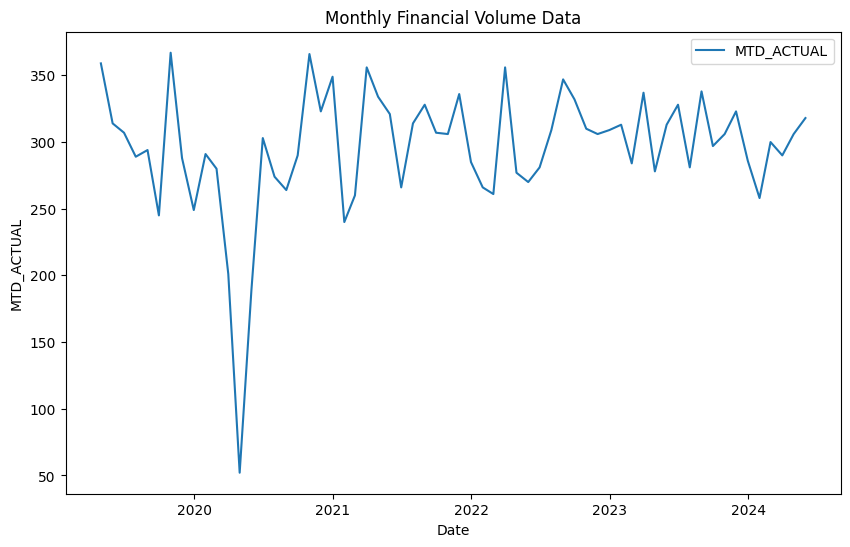

In [2]:
plt.figure(figsize=(10, 6))
plt.plot(data['ds'], data['y'], label='MTD_ACTUAL')
plt.xlabel('Date')
plt.ylabel('MTD_ACTUAL')
plt.title('Monthly Financial Volume Data')
plt.legend()
plt.show()

In [7]:
# 2. MODEL TRAINING AND HYPERPARAMETER TUNING ---------------------------------------

# Define a smaller grid of hyperparameters to search.
param_grid = {
    'changepoint_prior_scale': [0.1],  # Reduced the number of values
    'seasonality_prior_scale': [0.1],  # Reduced the number of values
    'holidays_prior_scale': [0.1]      # Reduced the number of values
}

# Splitting the data into training and testing sets.
train = data.iloc[:-12]
test = data.iloc[-12:]

# Preparing the future dataframe for the test set.
future_test = test[['ds', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']].copy()
future_test.reset_index(drop=True, inplace=True)

# Function to train and evaluate a model with given parameters
def evaluate_model(params):
    # Creating a Prophet model with the current set of hyperparameters.
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale']
    )
    model.add_regressor('month')
    model.add_regressor('quarter')
    model.add_regressor('year')
    model.add_regressor('lag_1')
    model.add_regressor('lag_2')
    model.add_regressor('lag_3')
    model.add_regressor('rolling_mean_3')
    model.add_regressor('rolling_std_3')
    
    # Fitting the model on the entire data.
    model.fit(data)

    # Making predictions for the test set.
    forecast_test = model.predict(future_test)

    # Calculating the error metrics.
    y_true = test['y'].values
    y_pred = forecast_test['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    return (params, mae, mse)

# Parallel processing with joblib
results = Parallel(n_jobs=-1)(delayed(evaluate_model)(params) for params in ParameterGrid(param_grid))

# Finding the best model
best_result = min(results, key=lambda x: x[1])
best_params, best_mae, best_mse = best_result

print(f"Best Params: {best_params}, Best MAE: {best_mae}, Best MSE: {best_mse}")

17:39:28 - cmdstanpy - INFO - Chain [1] start processing


Best Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}, Best MAE: 0.00013438479141332968, Best MSE: 2.1625693036996225e-08


17:39:56 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# 3. FINAL MODEL TRAINING AND PREDICTION --------------------------------------------

# Training the best model on the entire data.
model_best = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale']
)
model_best.add_regressor('month')
model_best.add_regressor('quarter')
model_best.add_regressor('year')
model_best.add_regressor('lag_1')
model_best.add_regressor('lag_2')
model_best.add_regressor('lag_3')
model_best.add_regressor('rolling_mean_3')
model_best.add_regressor('rolling_std_3')

# Fitting the best model on the entire data.
model_best.fit(data)

# Creating a future dataframe for the next 12 months.
future_full = model_best.make_future_dataframe(periods=12, freq='ME')
future_full['month'] = future_full['ds'].dt.month
future_full['quarter'] = future_full['ds'].dt.quarter
future_full['year'] = future_full['ds'].dt.year

# Setting lag features for the future dataframe based on the last observed values.
last_values = data.iloc[-1]
future_full['lag_1'] = last_values['y']
future_full['lag_2'] = last_values['lag_1']
future_full['lag_3'] = last_values['lag_2']
future_full['rolling_mean_3'] = data['y'].rolling(window=3).mean().iloc[-1]
future_full['rolling_std_3'] = data['y'].rolling(window=3).std().iloc[-1]

# Making predictions for the future.
forecast_full = model_best.predict(future_full)



17:40:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:02 - cmdstanpy - INFO - Chain [1] done processing


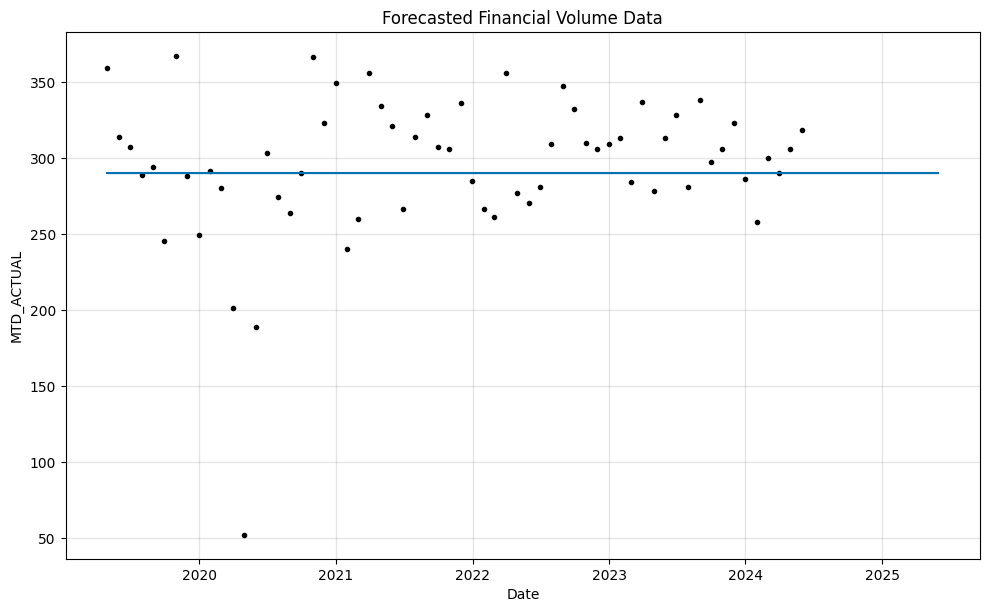

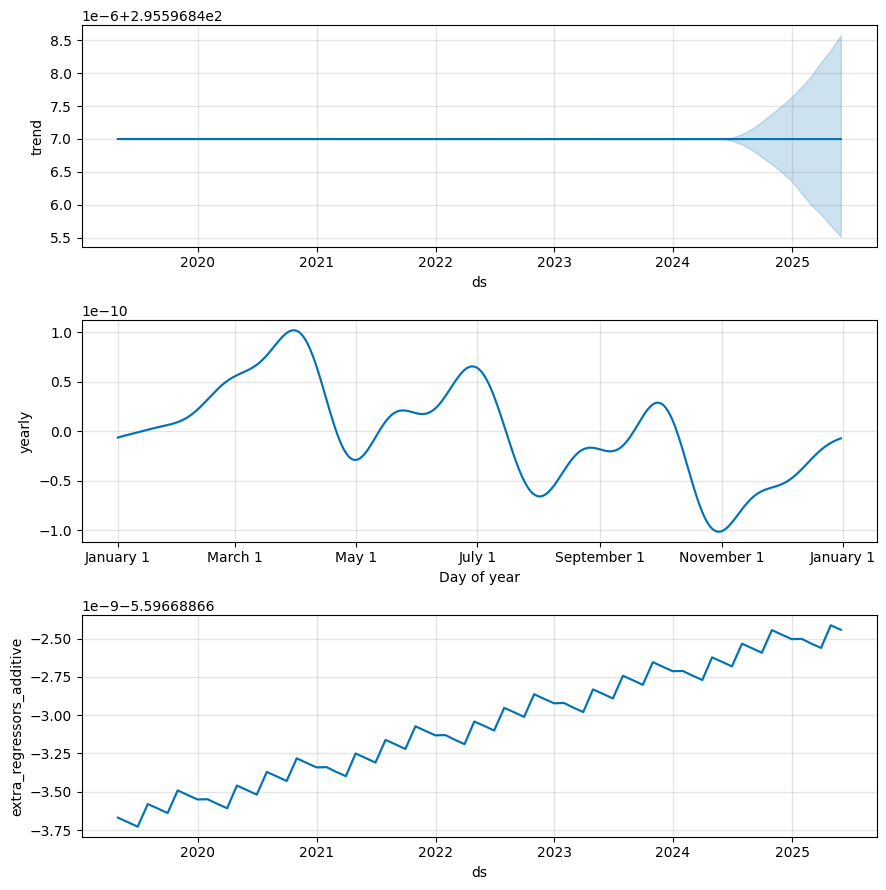

In [9]:
fig = model_best.plot(forecast_full)
plt.title('Forecasted Financial Volume Data')
plt.xlabel('Date')
plt.ylabel('MTD_ACTUAL')
plt.show()

fig2 = model_best.plot_components(forecast_full)
plt.show()

In [10]:
# Evaluating the final model on the test set.
forecast_test = model_best.predict(future_test)
y_true = test['y'].values
y_pred = forecast_test['yhat'].values

# Calculating the final error metrics.
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(f'Final Model MAE: {mae}, MSE: {mse}')

Final Model MAE: 0.00013438479141332968, MSE: 2.1625693036996225e-08
